##### <img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Signal Processing for Functional Brain Imaging Laboratories (MICRO-513)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Lab 1 - Preprocessing & GLM</font></h1>

<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: April 15, 2021</p>
    <p style="margin:4px;"><b>Submission</b>: April 20, 2021</span> 
</div>

## Student Name: Emery Sébastien

## Student SCIPER: 258565

Welcome to the first graded lab of MICRO-513! After filling the previous cell with your information, run the next cell to make sure that you have all required Python libraries installed. Once you have done that, run the cell below it to import all the libraries you will be using and to set up your environment. 

In [1]:
!pip install dipy
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install fury

In [2]:
# This section will import packages and functions needed for the rest of the notebook. 
import os, warnings, fnmatch, numpy as np, matplotlib.pyplot as plt, nibabel as nib
import dipy.align.imwarp as imwarp, scipy.ndimage as ndimage, pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)
from math import factorial
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass, AffineMap, MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D, AffineTransform3D)
from dipy.segment.mask import median_otsu
from dipy.segment.tissue import TissueClassifierHMRF
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
#from nistats.first_level_model import FirstLevelModel
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
import scipy.ndimage.morphology as morph

# We will save the results here in the following path, for the purpose, we will 
save_results = 'LAB1_data/AUDIO/results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
#* Set figure size
%matplotlib inline
plt.rcParams["figure.figsize"] = (11,8)

# Preprocessing & GLM

In this practical laboratory, you will be preprocessing and analyzing data from the [experiment](https://www.fil.ion.ucl.ac.uk/spm/data/auditory/) conducted by Geraint Rees under the direction of Karl Friston and the FIL methods group.

The experiment follows the next guidelines:
 * 96 acquisitions were made ($TR = 7s$), in blocks of $6$, giving $16$ blocks of $42 s$. 
 * The condition for successive blocks is alternated between rest and auditory stimulation, starting with rest. Auditory stimulation was with bi-syllabic words presented binaurally at a rate of 60 per minute. 
 * The functional data starts at acquisiton 4 (image `fM00223_004`). Due to $T1$ effects it is advisable to discard the first few scans (there were no "dummy" lead-in scans).

These whole brain BOLD/EPI images were acquired on a modified 2T Siemens MAGNETOM Vision system. Each acquisition consisted of 64 contiguous slices ($64\times 64\times 64, 3mm\times 3mm\times 3mm$  voxels). Acquisition took 6.05s, with the scan to scan repeat time (RT) set arbitrarily to 7s.

<div class = 'alert alert-success'>
    
**Note:** This Jupyter Notebook contains all the necessary code for the lab. To solve the notebook, you will need to read and execute the following sections. Pay attention to comments in the code section as they explain the workflow. You will be graded with Multiple Choice Questions (*MCQ*), where you will have several possible answers, only one of them correct. 
    
Good luck! We hope you enjoy the lab. 
</div>

## Index
1. [Preprocessing](#1.-Preprocessing)
    1. [Realignent](#1.A.-Realignment-(1-Point)) (**1 Point**)
    2. [Co-registration](#1.B.-Co-registration-(1-Point)) (**1 Point**)
    3. [Segmentation](#1.C.-Segmentation) 
    4. [Normalization](#1.D.-Normalization-(1-Point)) (**1 Point**)
    5. [Smoothing](#1.E.-Smoothing)
2. [GLM](#2.-GLM-(2-Points)) (**2 Points**)

# 1. Preprocessing

In this first section we will cover the most common preprocessing techniques, before building a *GLM*. We will compare the performance and the objectives of each of them using joint histograms and visualizing some of the results. Make sure to go through your [course notes](https://moodle.epfl.ch/pluginfile.php/1665520/mod_resource/content/8/2-Preprocessing.pdf) before going through this section, and make sure to understand every line of code, so that you learn the tools we will use. 

## 1.A. Realignment (1 Point)

In this first step, we will look at some characteristics of the data. First of all, run the next cell to load the 96 volumes and plot the mean volume. 

Mean image/volume:


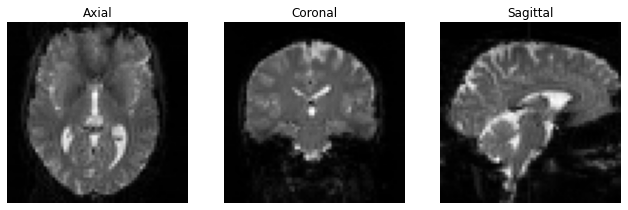

In [3]:
f_images = []
data_dir = 'LAB1_data/AUDIO/fM00223/' # Path to the img/hdr fMRI volumes
f_img_count = 96                      # nb of volumes
mean_image = np.zeros((64,64,64))     # volume size
for file_name in sorted(os.listdir(data_dir)):
    if fnmatch.fnmatch(file_name, '*.hdr'):
        f_images = f_images + [nib.load(data_dir+file_name)] 
        mean_image += np.squeeze(nib.load(data_dir+file_name).get_fdata())
        #nifti format of an image contains the actual 3D volume accessed by '.get_fdata()'
        #and in '.affine' matrix the sizes of voxels (in mm) and their translations in world coordinates,
        #on the diagonal and last column, respectively
mean_image /= f_img_count

#* Plot mean volume used as reference for realignment
regtools.plot_slices(mean_image, fname=save_results + "mean_functional_volume.png")
print("Mean image/volume:")

### MCQ

Now that you have plotted the mean volume, answer the next two questions to begin this lab. Each question is worth 0.5 points.  

 * Q.1 What are the dimensions (number of voxels in each direction) in an fMRI volume?
 
    1. $4\times 4\times 4$, so 64 voxels in total. 
    2. $64\times 64\times 64$, so 64 voxels in each direction.
    3. $64\times 4\times 4$, so 64 voxels in *one* direction.
    4. $8\times 8\times 1$, so 64 voxels in total.

In the next cell, **change the value of the variable `answer_q1`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

<div class = 'alert alert-info'>

**HINT:** If you need, you can also use the next cell to explore the data and extract information from the variables we declared in the previous cell.
</div>

In [4]:
# Do not change the name of this variable
answer_q1 = 2
# YOUR CODE HERE
# raise NotImplementedError()

In [5]:
assert answer_q1 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

 * Q.2 What is the size of the voxels in an fMRI volume?
 
    1. $3\times 3\times 3 mm^3$, 
    2. $\sqrt[\leftroot{-3}\uproot{3}3]{3}\times \sqrt[\leftroot{-3}\uproot{3}3]{3}\times \sqrt[\leftroot{-3}\uproot{3}3]{3} mm^3$,
    3. $27\times 27\times 27 mm^3$.

As in the last *MCQ*, **change the value of the variable `answer_q2`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [6]:
# Do not change the name of this variable
answer_q2 = 1
# YOUR CODE HERE
# raise NotImplementedError()

In [7]:
assert answer_q2 in [1, 2, 3], 'Valid answers are 1, 2, 3 and 4'

Great! Now that you are familiar with the data you will use, let's realign it. For the realignment of functional volumes, usually the Mean Squared Error (*MSE*) is used as objective function, since the data are from the same modality (i.e., all are functional volumes). In *DIPY*, there is no built-in *MSE* function for the realignment, so we use the mutual information (*MI*) as objective function. 

Run the next cell to minimize the *MI* of the volumes, and thus, realign them. Don't worry if it takes a bit of time, the cell will inform you the progress in any case. 

In [8]:
# Define parameters of realignment. We set mutual information as objective function
metric = MutualInformationMetric(nbins=32, sampling_proportion=None) # From Dipy
affreg = AffineRegistration(metric=metric,level_iters=[2],verbosity=0) # From Dipy
# Initialize list of realigned volumes
rf_images = []
tx=np.zeros((f_img_count,1));ty=np.zeros((f_img_count,1));tz=np.zeros((f_img_count,1));
rp=np.zeros((f_img_count,1));rr=np.zeros((f_img_count,1));ry=np.zeros((f_img_count,1));

# Perform realignment on all volumes
for i in range(f_img_count):
    moving_image = f_images[i]
    moving = np.squeeze(moving_image.get_fdata())
    # Set mean volume as reference
    rigid = affreg.optimize(mean_image, moving, RigidTransform3D(), params0=None) 
    transformed = rigid.transform(moving)       # Apply the rigid body transformation to the i'th volume
    tx[i] = -rigid.affine[0,3]                  # Translation along the x-axis in the i'th volume wrt reference
    ty[i] = rigid.affine[1,3]                   # Translation along the y-axis in the i'th volume wrt reference
    tz[i] = rigid.affine[2,3]                   # Translation along the z-axis in the i'th volume wrt reference
    rp[i] = np.arcsin(-rigid.affine[0,1])       # Rotaion around the Pitch axis in the i'th volume wrt reference
    rr[i] = np.arcsin(rigid.affine[0,2])        # Rotation around the Roll axis in the i'th volume wrt reference
    ry[i] = np.arcsin(-rigid.affine[1,2])       # Rotation around the Yaw axis in the i'th volume wrt reference
    rf_images += [transformed]
    if (not (i % 10)) or (i == 95): print("Running: Volume " + str(i+1) + "/96 Realigned.")

Running: Volume 1/96 Realigned.
Running: Volume 11/96 Realigned.
Running: Volume 21/96 Realigned.
Running: Volume 31/96 Realigned.
Running: Volume 41/96 Realigned.
Running: Volume 51/96 Realigned.
Running: Volume 61/96 Realigned.
Running: Volume 71/96 Realigned.
Running: Volume 81/96 Realigned.
Running: Volume 91/96 Realigned.
Running: Volume 96/96 Realigned.


Once the previous cell finishes, run the following cell to look at the realigning parameters for each of the volumes. We will plot translation and rotation parameters. After that, run the cell below it to compute and plot the *Framewise Displacement*. 

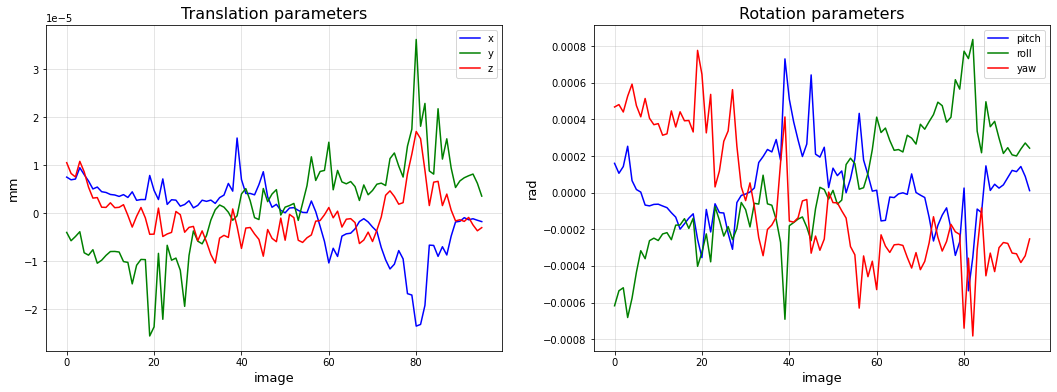

In [9]:
#* Print realignment parameters (translations and rotations)
fig = plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.plot(tx,'b')
plt.plot(ty,'g')
plt.plot(tz,'r')
plt.title('Translation parameters', size=16)
plt.xlabel('image', size=13)
plt.ylabel('mm', size=13)
plt.legend(['x','y','z'])
plt.grid(alpha=0.4)

plt.subplot(1,2,2)
plt.plot(rp,'b')
plt.plot(rr,'g')
plt.plot(ry,'r')
plt.title('Rotation parameters', size=16)
plt.xlabel('image', size=13)
plt.ylabel('rad', size=13)
plt.legend(['pitch','roll','yaw'])
plt.grid(alpha=0.4)

plt.savefig(save_results + "real_params.png", dpi=300) # Save as png 
plt.show()

(0.0, 0.2)

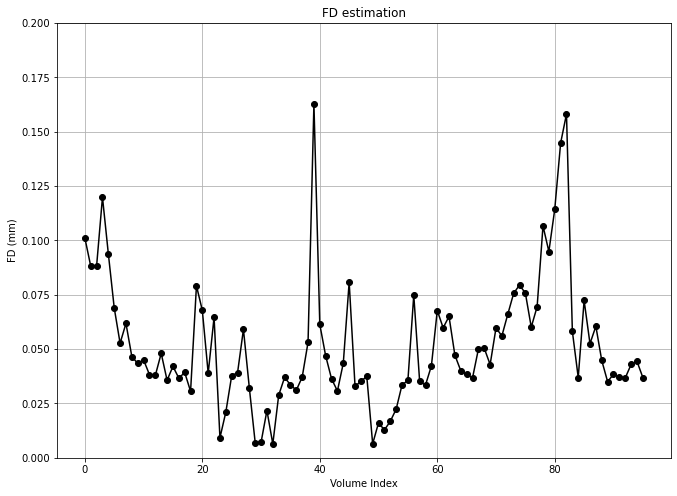

In [10]:
# Compute the Framewise Displacement (Power et al, NeuroImage, 2010)
head_radius = 50
rps = np.concatenate([tx,ty,tz, rp, rr, ry], axis=1)
# Convert rotations (radians) into displacements (mm)
rps[:, 3:] = head_radius*rps[:, 3:] 
FD = np.sum(abs(np.diff(rps, axis = 1)), 1); # estimate the FD
plt.plot(FD, 'o-', color='k'); plt.grid()
plt.xlabel("Volume Index"); plt.ylabel("FD (mm)"); plt.title("FD estimation"); plt.ylim([0,0.2])

Now that we have seen the metrics of the realignment process, we will look at an example. We want to look at the *sagittal*, *coronal* and *axial* views before and after realignment. Run the next cell to display the mean volume, the overlay and the result. 

Overlay before realignment (sagittal):


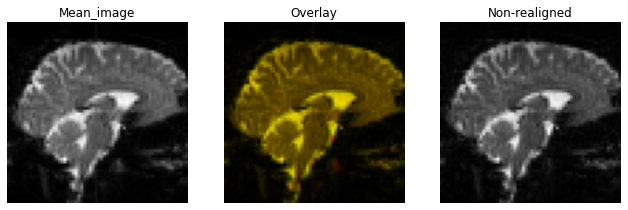

Overlay after realignment (sagittal):


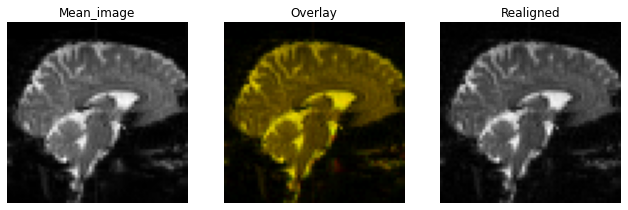

Overlay before realignment (coronal):


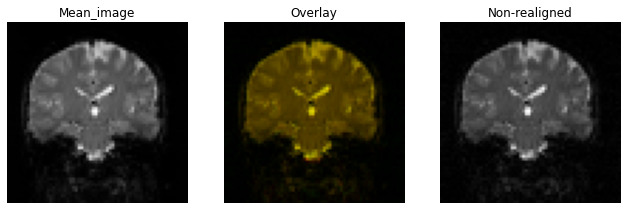

Overlay after realignment (coronal):


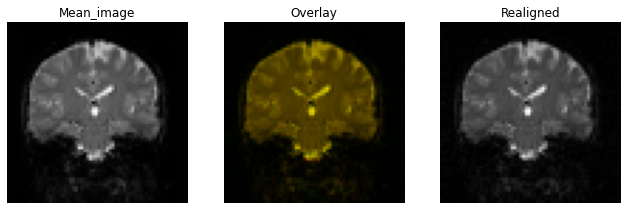

Overlay before realignment (axial):


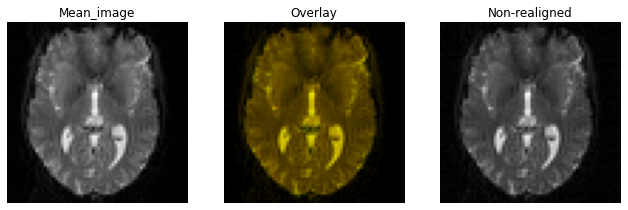

Overlay after realignment (axial):


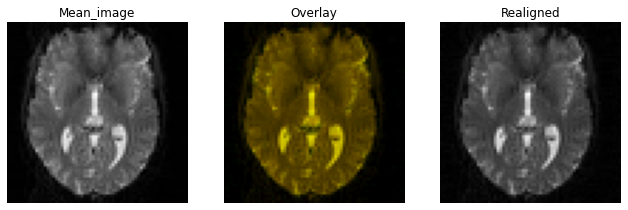

In [11]:
# Print the first volume before and after realignment
volume_index=0 #index of the volume pair to visualize
nonrealigned = np.squeeze(f_images[volume_index].get_fdata()) # A typical fMRI volume before realignment
transf_image = rf_images[volume_index]                        # The same fMRI volume after realignment

# Display sagittal view of the volume
print("Overlay before realignment (sagittal):")
regtools.overlay_slices(mean_image, nonrealigned, None, 0,
                        "Mean_image", "Non-realigned", save_results + "funct_0.png")
plt.show()
regtools.overlay_slices(mean_image, transf_image, None, 0,
                        "Mean_image", "Realigned", save_results + "funct_align_0.png")
print("Overlay after realignment (sagittal):")
plt.show()


# Display coronal view of the volume
print("Overlay before realignment (coronal):")
regtools.overlay_slices(mean_image, nonrealigned, None, 1,
                        "Mean_image", "Non-realigned", save_results + "funct_1.png")
plt.show()
regtools.overlay_slices(mean_image, transf_image, None, 1,
                        "Mean_image", "Realigned", save_results + "funct_align_1.png")
print("Overlay after realignment (coronal):")
plt.show()

# Display axial view of the volume
print("Overlay before realignment (axial):")
regtools.overlay_slices(mean_image, nonrealigned, None, 2,
                        "Mean_image", "Non-realigned", save_results + "funct_2.png")
plt.show()
regtools.overlay_slices(mean_image, transf_image, None, 2,
                        "Mean_image", "Realigned", save_results + "funct_align_2.png")
print("Overlay after realignment (axial):")

Another metric that we can look at is the *MSE*. We will calculate it with respect to the reference `mean_image`, for both the non-aligned and the realigned versions. Moreover, we will plot joint histograms of:
 * the target mean image vs non-aligned, and 
 * the target mean image vs the realigned volume. 
 
We will overlay the joint histograms  to see the comparison of the realignment. Note that if we were comparing the mean image to itself, we would expect a *MSE* of $0$ and a completely diagonal joint histogram (as every voxel is exactly equal to the voxel in the image we are comparing it to). So these are the metrics that we are aiming for. We will do it for the first volume. 


 Joint histograms:


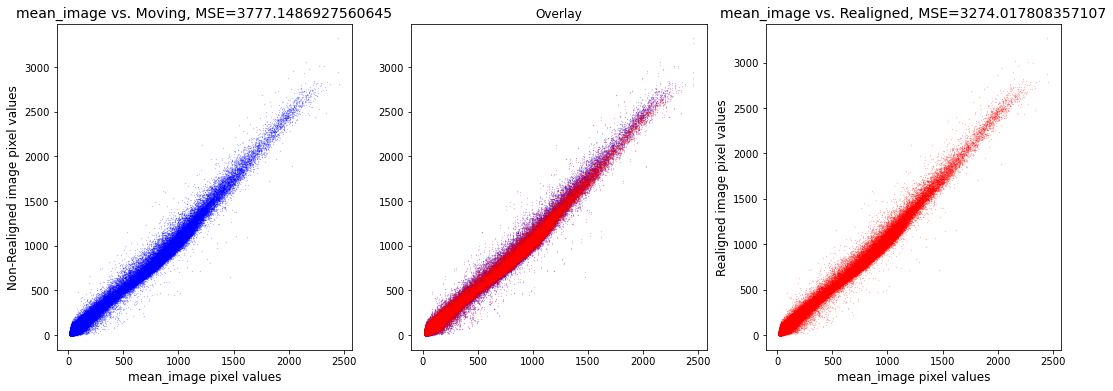

In [12]:
#* Plots joint histograms of pairs: mean_image (reference) and moving volume, and mean_image and realigned volume
#* Calculate MSE between (non)realigned image and the reference mean image
mse_before = ((mean_image.flatten() - f_images[0].get_fdata().flatten())**2).mean()
mse_after = ((mean_image.flatten() - rf_images[0].flatten())**2).mean()

print("\n Joint histograms:")
fig = plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.plot(mean_image.flatten(),f_images[0].get_fdata().flatten(),'b.',markersize=0.5, alpha = 0.4)
plt.title('mean_image vs. Moving, MSE='+str(mse_before), size=14)
plt.xlabel('mean_image pixel values', size=12)
plt.ylabel('Non-Realigned image pixel values', size=12)

plt.subplot(1,3,2)
plt.plot(mean_image.flatten(),f_images[0].get_fdata().flatten(),'b.',markersize=0.5, alpha = 0.4)
plt.plot(mean_image.flatten(),rf_images[0].flatten(),'r.',markersize=0.5, alpha = 0.4)
plt.title('Overlay')

plt.subplot(1,3,3)
plt.plot(mean_image.flatten(),rf_images[0].flatten(), 'r.',markersize=0.5, alpha = 0.4)
plt.title('mean_image vs. Realigned, MSE='+str(mse_after), size=14)
plt.xlabel('mean_image pixel values', size=12)
plt.ylabel('Realigned image pixel values', size=12)

plt.savefig(save_results + "Joint_histograms_realignment.png", dpi = 300)
plt.show()

### MCQ 
To finish this section, answer the next *MCQ* (worth 1 point).

 * Q.3 What can you say about the nature of the *fMRI* data considering that the joint histogram is already quite diagonal before realignment? Near-diagonal joint histogram of original and realigned volume suggests that...

    1. There was probably **not much** movement inside the scanner that would confound the data.
    3. Realignment **did not** work.
    2. There was probably a lot of movement inside the scanner that confounded the data. 
    4. *MI* is not a good metric for realignment. 

As before, change the variable `answer_q3` in the next cell to reflect your choicem then run the cell below it to check that your answer is valid.   

In [13]:
# Do not change the name of this variable
answer_q3 = 1
# YOUR CODE HERE
# raise NotImplementedError()

In [14]:
assert answer_q3 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4.'

## 1.B. Co-registration (1 Point)
[Back to Index](#Index)

The main differences between Co-registration and realignment is that co-registration includes scaling, and can be done across different modalities and subjects.

In this case, we will also set the mean image as a reference, and we will co-register the structural *MRI* volume. Run the next cell to declare the reference and the structural *MRI* (we will use the first volume).

In [15]:
# Define mean fMRI volume as reference image, and structural MRI volume as the one being co-registered
refer = mean_image.copy()
refer_grid2world = f_images[0].affine
struct_image = nib.load('LAB1_data/AUDIO/sM00223/sM00223_002.img')
struct = np.squeeze(struct_image.get_fdata())
struct_grid2world = struct_image.affine
affine_map = AffineMap(np.eye(4),
                       refer.shape, refer_grid2world,
                       struct.shape, struct_grid2world)
resampled = affine_map.transform(struct)

Before actually doing co-registration, we will first align the center of mass and look at the results. This will serve as a quick assesment of a need for co-registration. For the purpose, we will use the function `transform_centers_of_mass` from *DIPY*. Run the next cell to plot the results, before and after mass-centering. 

Overlay before co-registration


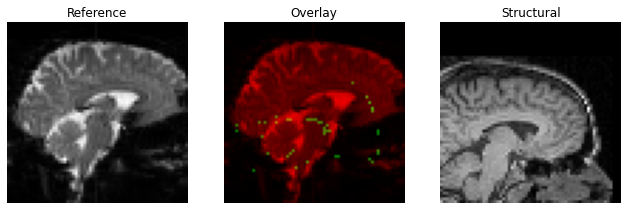

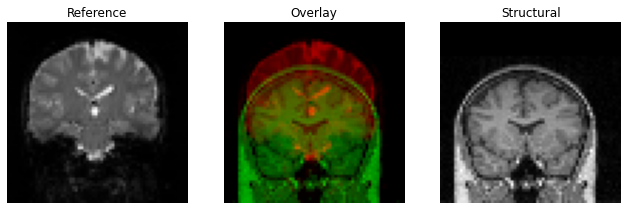

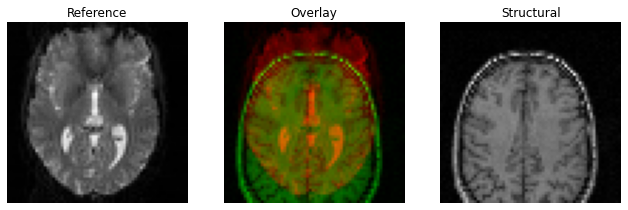

Overlay after center of mass transformation


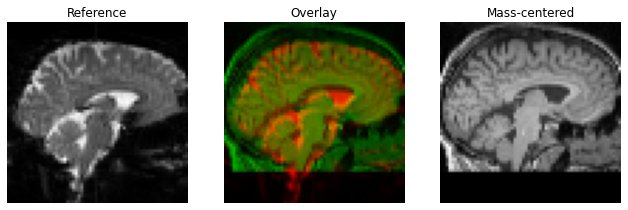

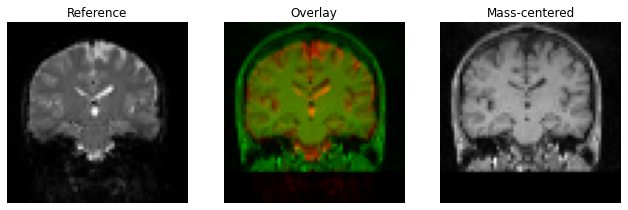

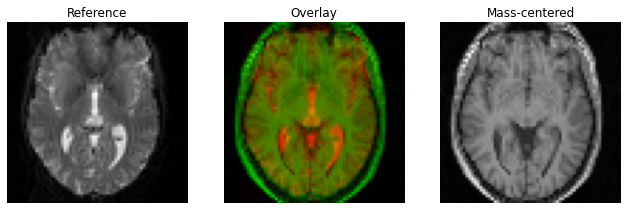

In [16]:
c_of_mass = transform_centers_of_mass(refer, refer_grid2world,
                                      struct, struct_grid2world)
transformed = c_of_mass.transform(struct)

# Plot reference and structural volume before centering of mass
regtools.overlay_slices(refer, resampled, None, 0,
                        "Reference", "Structural", save_results + "struct_0.png")
regtools.overlay_slices(refer, resampled, None, 1,
                        "Reference", "Structural", save_results + "struct_1.png")
regtools.overlay_slices(refer, resampled, None, 2,
                        "Reference", "Structural", save_results + "struct_2.png")
print("Overlay before co-registration")
plt.show()


# Plot reference and structural volume after centering of mass
regtools.overlay_slices(refer, transformed, None, 0,
                        "Reference", "Mass-centered", save_results + "struct_COM_0.png")
regtools.overlay_slices(refer, transformed, None, 1,
                        "Reference", "Mass-centered", save_results + "struct_COM_1.png")
regtools.overlay_slices(refer, transformed, None, 2,
                        "Reference", "Mass-centered", save_results + "struct_COM_2.png")
print("Overlay after center of mass transformation")

Now we will actually do co-registration, again using *MI* as a metric. Run the next cell to co-register the first volume.  


 Overlay after (affine) co-registration


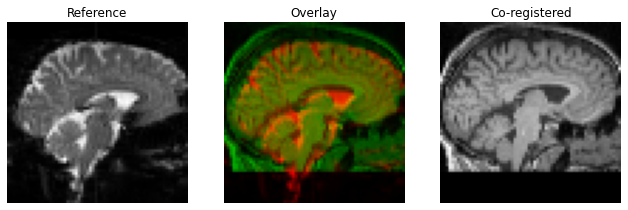

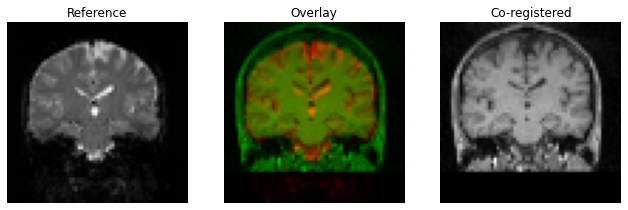

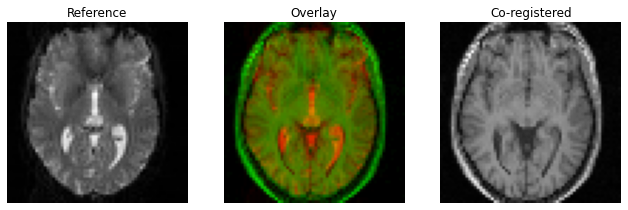

In [17]:
#* Define parameters of co-registration
metric = MutualInformationMetric(nbins=32, sampling_proportion=None) #Mutual information as optimization criterion
params0 = None
affreg = AffineRegistration(metric=metric, level_iters=[10000, 1000, 100],
                            sigmas=[3.0, 1.0, 0.0], factors=[4, 2, 1], verbosity=0)
affine = affreg.optimize(refer, struct, AffineTransform3D(), params0,
                         refer_grid2world, struct_grid2world,
                         starting_affine=c_of_mass.affine)


#* Perform co-registration. Note that this is a linear transformation. 
# Nonlinear co-registration is likely a more accurate matching method between the two modalities.
s_image = affine.transform(struct)


#* Plot reference and structural volume after co-registration
regtools.overlay_slices(refer, transformed, None, 0,
                        "Reference", "Co-registered", save_results + "struct_coreg_0.png")
regtools.overlay_slices(refer, transformed, None, 1,
                        "Reference", "Co-registered", save_results + "struct_coreg_1.png")
regtools.overlay_slices(refer, transformed, None, 2,
                        "Reference", "Co-registered", save_results + "struct_coreg_2.png")
print("\n Overlay after (affine) co-registration")

Now, as we did in [section 1.A](#1.A.-Realignment-(1-Point)), we will plot the joint histograms of the reference vs the structural volume, both before and after realignment. Run the next cell to look at these joint histograms, and its overlay. Ask yourself the questions, why do the joint histograms have that shape and not a diagonal shape? Do we want a diagonal shape?


 Joint histograms


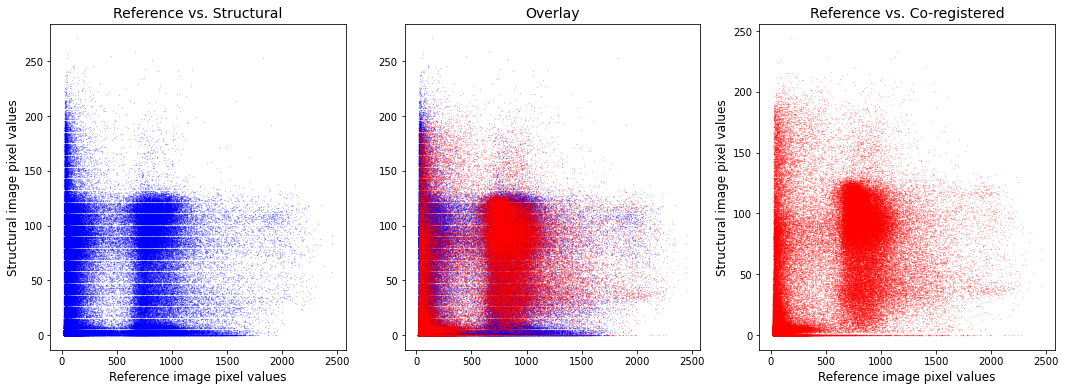

In [18]:
#* Plots joint histograms of pairs: reference and structural volume,
# and reference and co-registered structural volume

print("\n Joint histograms")
fig = plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.plot(refer.flatten(),resampled.flatten(),'b.',markersize=0.5,alpha = 0.4)
plt.title('Reference vs. Structural', size=14)
plt.xlabel('Reference image pixel values', size=12)
plt.ylabel('Structural image pixel values', size=12)

plt.subplot(1,3,2)
plt.plot(refer.flatten(),resampled.flatten(),'b.',markersize=0.5,alpha = 0.4)
plt.plot(refer.flatten(),s_image.flatten(),'r.',markersize=0.5,alpha = 0.4)
plt.title('Overlay', size=14)

plt.subplot(1,3,3)
plt.plot(refer.flatten(),s_image.flatten(),'r.',markersize=0.5,alpha = 0.4)
plt.title('Reference vs. Co-registered', size=14)
plt.xlabel('Reference image pixel values', size=12)
plt.ylabel('Structural image pixel values', size=12)

plt.savefig(save_results + "Joint_histograms_co-registration.png", dpi = 300)
plt.show()

### MCQ

After looking at the joint histograms, for 1 point, answer the following *MCQ*. 

 * Q.4 Why is *MI* a favorable metric for co-registration, in comparison to the *MSE*?

    1. Because in *DIPY*, there is no built-in *MSE* function.
    2. Minimization of *MSE* would not produce satisfactory results because cerebrospinal fluid and gray matter have higher values (i.e. look brighter) and white matter has lower values (i.e. looks darker)
    3. Minimization of *MSE* would not produce satisfactory results because fMRI volumes and structural volumes are recorded with a different technique. 
    4. *MI* has a lower complexity (meaning that it can be computed faster) than *MSE*. 

Change the variable `answer_q4` in the next cell to reflect your choice, then run the cell below it to check that your answer is valid.  

In [19]:
# Do not change the name of this variable
answer_q4 = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [20]:
assert answer_q4 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4.'

## 1.C. Segmentation
[Back to Index](#Index)

Segmentation refers to the use of image processing techniques to extract specific regions of an image. To start this section, we will use morphological operators to get rid of the skull. Run the next cell and look at it in detail, to understand how do we get rid of the skull. What is the key feature in the volume (and thus, in the skull and brain) that allows us to remove the skull using onl morphological operators?

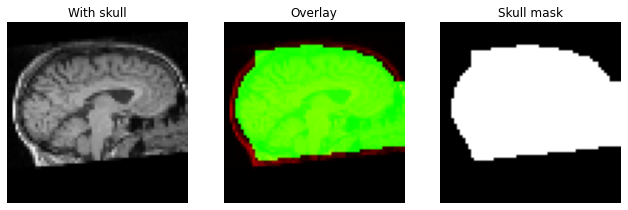

In [21]:
# Skull removal using morphological image processing. First we define our skull mask
skull_mask = s_image.copy()
# We apply a binarization using a threshold of 12. 
# This means that almost all information in the image will be thresholded to 1, and the background to 0
th = 12
skull_mask[skull_mask<th] = 0
skull_mask[skull_mask>=th] = 1
# We perform a morphological closing to remove small holes (of value 0) and avoid noise in the rest of the process
strsz = 3
skull_mask=morph.grey_closing(skull_mask, [strsz, strsz, strsz])
# Now an erosion, so that we make the skull disappear 
strsz = 5
skull_mask = morph.grey_erosion(skull_mask, [strsz, strsz, strsz])
# Now that we have a mask withoug skull (the regions with skull are simply full of zeros), we will perform a matrix 
# multiplication with the original, so that we keep only region of interest
s_image_noskull = skull_mask*s_image

regtools.overlay_slices(s_image, skull_mask, None, 0,
                        "With skull", "Skull mask")
plt.show()

Run the next cell to look at the results. We will plot the image before and after removing the skull, to be able to make a comparison.


 The Structural image before skull removal


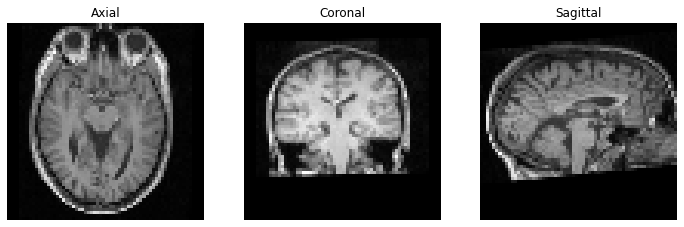


 The Structural image after skull removal


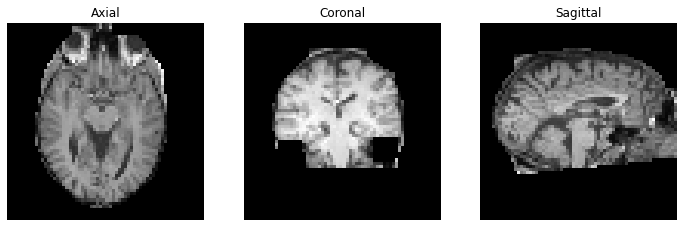

In [22]:
# Plot structural image before removing the skull
fig = plt.figure(figsize=[12,10])
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(s_image[..., 31])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('Axial')
a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(s_image[:, 31, :])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Coronal')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(s_image[31, :, :])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Sagittal')
print("\n The Structural image before skull removal")
# Save results and plot
plt.savefig(save_results + 'struct_slices.png', bbox_inches='tight', pad_inches=0);
plt.show()

# Plot structural image after removing the skull
fig = plt.figure(figsize=[12,10])
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(s_image_noskull[..., 31])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('Axial')
a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(s_image_noskull[:, 31, :])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Coronal')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(s_image_noskull[31, :, :])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Sagittal')
print("\n The Structural image after skull removal")
# Save results and plot
plt.savefig(save_results + 'struct_slices_no_skull.png', bbox_inches='tight', pad_inches=0);

Now that we got rid of the region that we definitely do not want (the skull), let's segment the image into the 3 regions that we actually care about:
 * Corticospinal fluid (CSF),
 * White matter (WM), and
 * Gray matter (GM)
 
For the purpose, we will use the class `TissueClassifier`, provided by *DIPY* in the module `segment`. Run the next cell and look at it in detail to see how segmentation is done.

In [23]:
# We define 3 classes,  as we have 3 tissues that we care about
nclass = 3
# Smoothness factor
beta = 0 
# Use Otus's threshold to generate a mask
b0_mask, mask = median_otsu(s_image, median_radius=4, numpass=8)
# Initialize classifier
hmrf = TissueClassifierHMRF(verbose=False)
# We get the classifications in the variable PVE (tissue probability maps - all values between 0 and 1)
initial_segmentation, final_segmentation, PVE = hmrf.classify(b0_mask, nclass, beta)
# Let's not forget to get rid of the skull, by performing element-wise multiplication with the skull_mask. 
PVE[..., 0] = PVE[..., 0] * skull_mask # Size of PVE: N_x x N_y x N_z x N_T
PVE[..., 1] = PVE[..., 1] * skull_mask
PVE[..., 2] = PVE[..., 2] * skull_mask

Run the next cell to look at the results of the segmentation. 

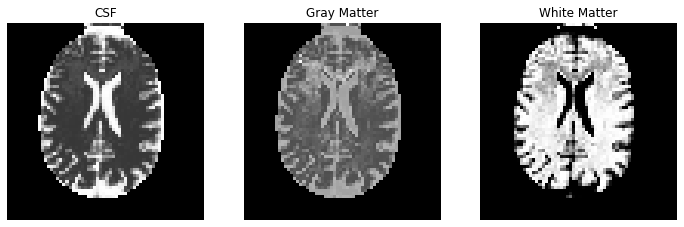

In [24]:
# Plot segmented maps of the 39th slice.
slice_idx = 39

fig = plt.figure(figsize=[12,10])
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(PVE[..., slice_idx, 0])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('CSF')

a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(PVE[:, :, slice_idx, 1])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Gray Matter')

a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(PVE[:, :, slice_idx, 2])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('White Matter')
plt.savefig(save_results + 'segmentation_prob.png', bbox_inches='tight', pad_inches=0)
plt.show()

## 1.D. Normalization (1 Point)
[Back to Index](#Index)

This step, referred in neuroimaging as spatial normalization, has the purpose of making a region of the brain have the same location in every volume. This differs from co-registration as we did it in section [1.B](#1.B.-Co-registration-(1-Point)) because co-registration only applies translation, rotation and scaling. Spatial normalization on the otherhand will spatially deform a volume. 

Run the next cell to define the mean (over all subjects) structural volume as a target for normalization. We will also save it as an image and plot it.


 The Template Image:


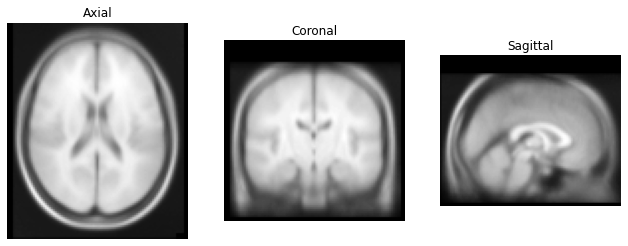

In [25]:
#* Define and plot target for normalization
template = nib.load('LAB1_data/AUDIO/avg305T1.nii')
regtools.plot_slices(template.get_fdata(), fname=save_results+ 'Template.png')
print("\n The Template Image:")

Now that we have our target, we will normalize all the volumes. We will use cross-correlation as a metric. Run the next cell to normalize every every volume. Do not worry if it takes a long time, it will inform you of the proress in any case. 

In [26]:
# Define normalization parameters
metric = CCMetric(dim=3, sigma_diff=0) #cross-correlation as optimization metric
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters=[40, 20, 10], inv_iter = 50)
c_of_mass = transform_centers_of_mass(template.get_fdata(), template.affine,
                                     s_image, f_images[0].affine)
mapping = sdr.optimize(template.get_fdata(), s_image, template.affine, f_images[0].affine, c_of_mass.affine)

#* Perform normalization
wrf_images = []
for i in range(f_img_count):
    wrf_images.append(mapping.transform(rf_images[i])) #* normalization of realigned fMRI volumes
    if (not (i % 10)) or (i==95): print("Running: Func. Volume " + str(i+1) + "/96 Normalized.")
    
normalized_struct_image = mapping.transform(s_image) #* normalization of structural volume
print("Struc. Volume Normalized.")

Running: Func. Volume 1/96 Normalized.
Running: Func. Volume 11/96 Normalized.
Running: Func. Volume 21/96 Normalized.
Running: Func. Volume 31/96 Normalized.
Running: Func. Volume 41/96 Normalized.
Running: Func. Volume 51/96 Normalized.
Running: Func. Volume 61/96 Normalized.
Running: Func. Volume 71/96 Normalized.
Running: Func. Volume 81/96 Normalized.
Running: Func. Volume 91/96 Normalized.
Running: Func. Volume 96/96 Normalized.
Struc. Volume Normalized.


Now run the next two cells to look at the results. We will plot the *sagittal*, *coronal* and *axial* views before and after normalization. In the first cell, we will plot the structural volume, and in the second cell we will plot the *fMRI* volume. 

Overlay before normalization (structural volume)


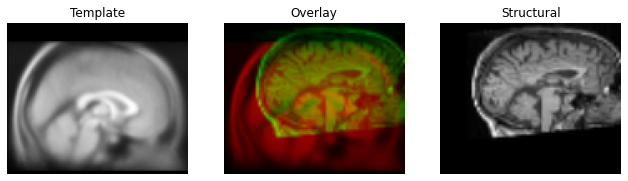

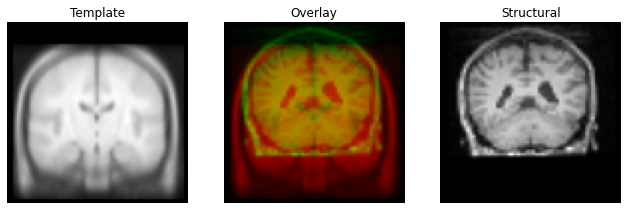

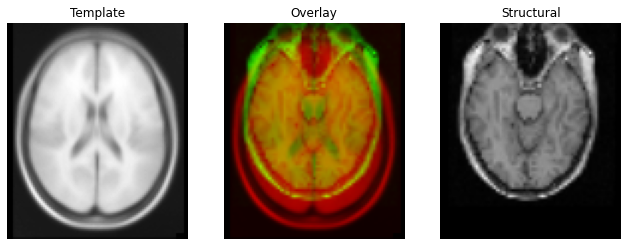

Overlay after normalization (structural volume)


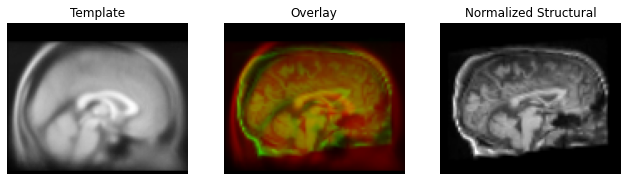

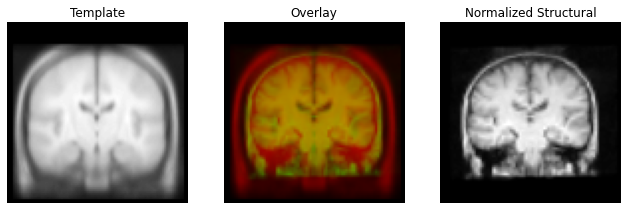

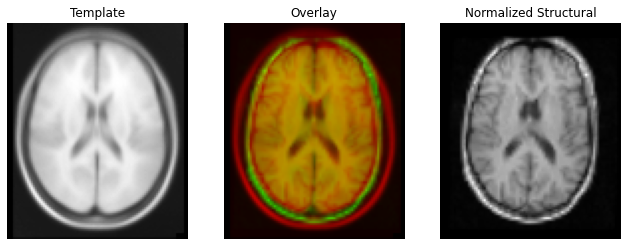

In [27]:
#* Plot template and structural image before normalization
affine_map = AffineMap(np.eye(4), template.get_fdata().shape, template.affine,
                       s_image.shape, f_images[0].affine)
resampled = affine_map.transform(s_image)
regtools.overlay_slices(template.get_fdata(), resampled, None, 0, "Template", "Structural")
regtools.overlay_slices(template.get_fdata(), resampled, None, 1, "Template", "Structural")
regtools.overlay_slices(template.get_fdata(), resampled, None, 2, "Template", "Structural")
print('Overlay before normalization (structural volume)')
plt.show()


#* Plot template and structural image after normalization
regtools.overlay_slices(template.get_fdata(), normalized_struct_image, None, 0,
                        "Template", "Normalized Structural", save_results + "struct_norm_0.png")
regtools.overlay_slices(template.get_fdata(), normalized_struct_image, None, 1,
                        "Template", "Normalized Structural", save_results + "struct_norm_1.png")
regtools.overlay_slices(template.get_fdata(), normalized_struct_image, None, 2,
                        "Template", "Normalized Structural", save_results + "struct_norm_2.png")
print("Overlay after normalization (structural volume)")


 Overlay before normalization (functional volume)


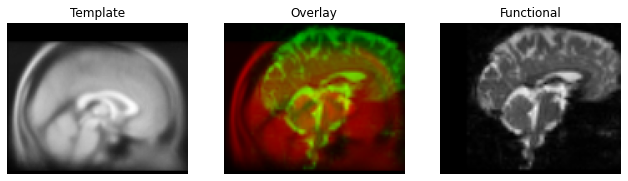

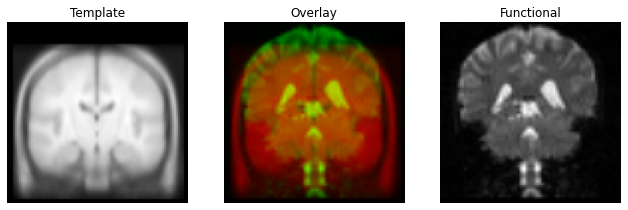

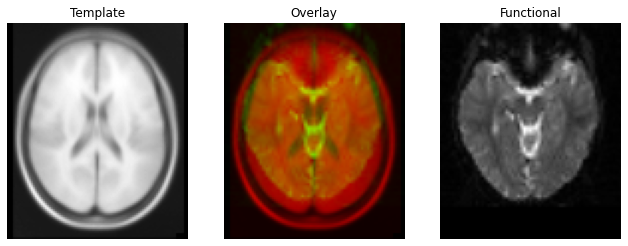


 Overlay after normalization (functional volume)


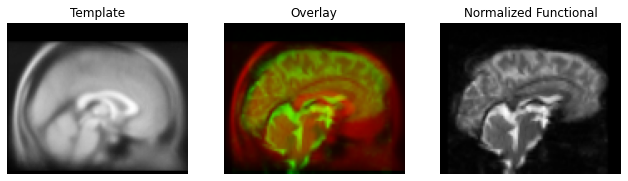

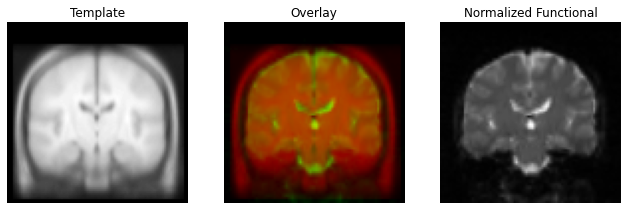

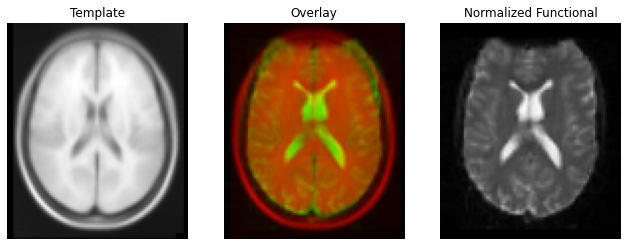

In [28]:
#* Plot template and functional image before normalization
affine_map = AffineMap(np.eye(4),
                       template.get_fdata().shape, template.affine,
                       rf_images[0].shape, f_images[0].affine)
resampled = affine_map.transform(rf_images[0])
regtools.overlay_slices(template.get_fdata(), resampled, None, 0,
                        "Template", "Functional")
regtools.overlay_slices(template.get_fdata(), resampled, None, 1,
                        "Template", "Functional")
regtools.overlay_slices(template.get_fdata(), resampled, None, 2,
                        "Template", "Functional")
print('\n Overlay before normalization (functional volume)')
plt.show()


#* Plot template and functional image after normalization
regtools.overlay_slices(template.get_fdata(), wrf_images[0], None, 0,
                        "Template", "Normalized Functional", save_results + "funct_norm_0.png")
regtools.overlay_slices(template.get_fdata(), wrf_images[0], None, 1,
                        "Template", "Normalized Functional", save_results + "funct_norm_1.png")
regtools.overlay_slices(template.get_fdata(), wrf_images[0], None, 2,
                        "Template", "Normalized Functional", save_results + "funct_norm_2.png")
print("\n Overlay after normalization (functional volume)")

### MCQ

No that you have looked at the results of normalization, answer the following *MCQ*. 
 * Q.5 Why it is neccesary to perform normalization in a study including more than one subject?
 
    1. It is not. Co-registration is a good enough pre-processing technique. 
    2. Different subjects have significantly different brain anatomy. Thus, a simple overlay of either the structural or the *fMRI* volume will not be a good fit.
    3. We need the average for each subject to be zero. Therefore we need to normalize the data.
    4. Because otherwise some subjects will carry more weight in the linear regression.

As usual, change the value of the variable `answer_q5` in the next cell to your answer. Then run the cell below it to check the validity of your answer. 

In [29]:
# Do not change the name of this variable
answer_q5 = 2
# YOUR CODE HERE
# raise NotImplementedError()

In [30]:
assert answer_q5 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

## 1.E. Smoothing
[Back to Index](#Index)

To finish the preprocessing section, we will look at a simple smoothing technique. While our eyes (and brains) are not used to looking at smoothed or blurred images, and we intuitively find the images low quality, smoothing is in fact a very efficient noise removal technique. For the computational tools that we use to analyse the volumes resulting from an experiment like the one we are analysing, smoothing is an essential preprocessing step, and it improves the reliability of further processing. 

For the purpose we will be using the simple [Gaussian smoothing](https://en.wikipedia.org/wiki/Gaussian_blur), as implemented by the `ndimage` module of SciPy. We will apply it on the normalized volumes, as it is the final preprocessing step. Run the next two cells to smooth all the volumes, and then to save and plot the results before and after smoothing.

In [31]:
#* Smoothen all the normalized functional volumes
swrf_images = []
for i in range(f_img_count):
    img = ndimage.gaussian_filter(wrf_images[i], sigma=(3, 3, 3), order=0) #Gaussian filter
    swrf_images.append(img)


 Volume before smoothing


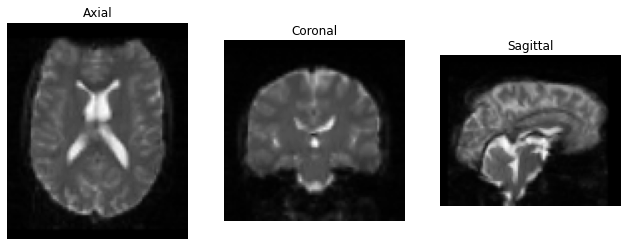


 Volume after smoothing


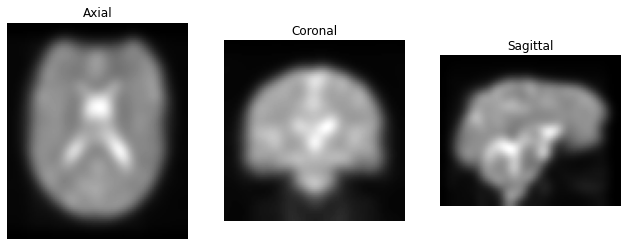

In [32]:
#* Plot first volume before smoothing
regtools.plot_slices(wrf_images[0], fname=save_results+'before_smoothing.png')
print("\n Volume before smoothing")
plt.show()

#* Plot first volume after smoothing
regtools.plot_slices(swrf_images[0], fname=save_results+'after_smoothing.png')
print("\n Volume after smoothing")

# 2. GLM (2 Points)
[Back to Index](#Index)

Now that we have finished the preprocessing of the images, let's actually build a General Linear Model (*GLM*) For a review on *GLM* you can read [this reference](https://moodle.epfl.ch/pluginfile.php/1667261/mod_resource/content/2/Review_GLM.pdf) or look at your course notes. 

To model the neural activation that could be expected from a task-responsive voxel in a block design experiment like the one we are using, we will use a boxcar model. Run the following cell to define this boxcar model.

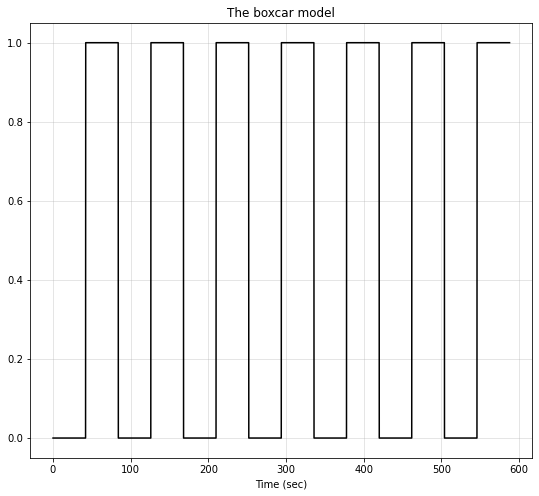

In [33]:
#* Define the boxcar function
TR = 7
# number of timepoints in the fMRI timecourse (first 12 volumes will not be considered)
nTRs = f_img_count - 12
t = np.arange(0,TR*nTRs,0.1)
box = np.zeros(TR*nTRs*10)
for i in range(14):
    if i % 2 == 1:
        box[i*6*TR*10:(i+1)*6*TR*10] = 1

#* Plot the boxcar function
plt.figure(figsize=(9,8))
plt.plot(t, box, 'k')
plt.xlabel('Time (sec)'); plt.grid(alpha=0.4); plt.title("The boxcar model")
plt.savefig(save_results+'boxcar_model.png', dpi = 200)
plt.show()

Now run the next cell to define and plot a haemodynamic response function (*HRF*). 

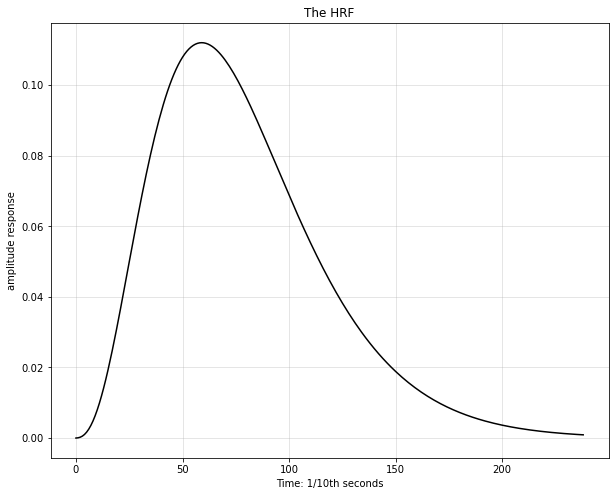

In [34]:
#* Define and plot the HRF (gamma functions)
T0 = 0
n = 4
lamda = 2
hrf = np.power((t-T0),(n-1))*np.exp(-(t-T0)/lamda)/((pow(lamda,n)*factorial(n-1)))
plt.figure(figsize=(10,8))
plt.plot(hrf[1:240], 'k'); plt.grid(alpha=0.4)
plt.xlabel('Time: 1/10th seconds'); plt.title("The HRF"); plt.ylabel("amplitude response")
plt.savefig(save_results+'HRF.png', dpi = 200)
plt.show() # in 1/10th sec for smooth plot

Finally, let's convolve the *HRF* with the boxcar function and discretize the result (remember that bold data was acquired every 7 sec, so the experiment had 84 time points).

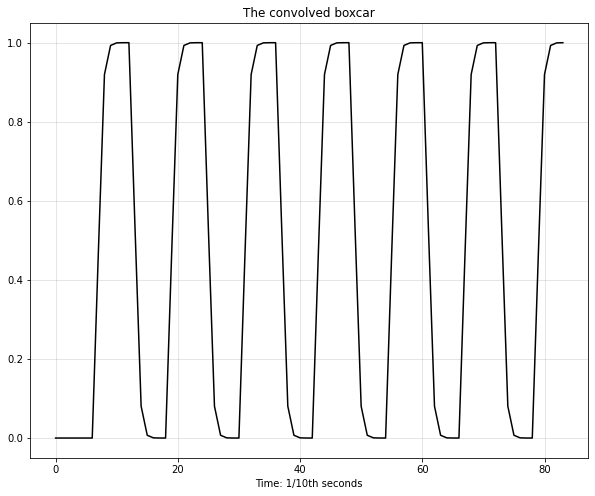

In [35]:
#* Convolve the HRF and boxcar and then discretize (BOLD data was acquired every 7 sec, 
# so the experiment had 84 time points)
B = np.convolve(hrf,box)/10
N = np.empty(nTRs)
for i in range(nTRs):
    N[i]=B[i*70];

#* Plot boxcar convolved with HRF
plt.figure(figsize=(10,8))
plt.plot(N, 'k'); plt.grid(alpha=0.4)
plt.xlabel('Time: 1/10th seconds'); plt.title("The convolved boxcar")
plt.savefig(save_results+'convolved_boxcar_model.png', dpi = 300)
plt.show()

In the following cell we will build and plot a design matrix for our GLM. 

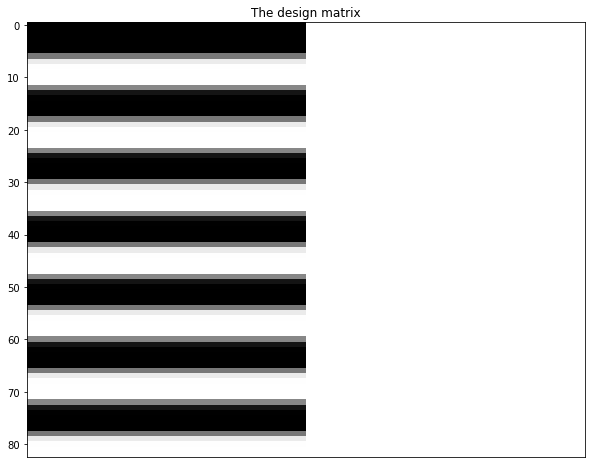

In [36]:
#* Build design matrix for GLM
design_matrix = np.zeros((nTRs,2)) # initialize matrix
design_matrix[:,1]=np.ones(nTRs) # regressor for baseline activity
design_matrix[:,0] = N # convolved boxcar as regressor
design_matrix = pd.DataFrame({'active': design_matrix[:, 0], 'constant': design_matrix[:, 1]})

#* Plot design matrix
plt.figure(figsize=(10,8));plt.xticks([])
plt.imshow(np.vstack([N[1:240],np.ones(len(N[1:240]))]).T, aspect='auto', cmap='gray')
plt.title("The design matrix")
plt.savefig(save_results+'design_matrix.png', dpi = 300)
plt.show()

Now we just have to format our data to nifti format (needed for GLM routine). Run the next cell to reshape our preprocessed NumPy Array to a 4D Array of dimensions $(91, 109, 91, 84)$.

In [37]:
#* Reshape preprocessed numpy array of 3D fMRI data to 4D numpy array (dimension 91,109,91,84),
# and then convert it to nifti format (needed for GLM routine)
img_np = np.zeros((91,109,91,96))
for i in range(96):
    img_np[:,:,:,i] = swrf_images[i]
ni_img = nib.Nifti1Image(np.array(img_np[:,:,:,12:]), f_images[0].affine) #remove first 12 volumes
print(ni_img.shape)

#* Convert normalized_struct_image to nifti format (needed for plotting background)
ni_struct_img = nib.Nifti1Image(np.array(normalized_struct_image), f_images[0].affine)

(91, 109, 91, 84)


Now that we have everything (or design matrix and our data in nifti format), we can perform a General Linear Model (First Level Analysis). Run the next cell to perform it, and the cell below it to plot the statistical parameter map. 

In [38]:
#* Perform GLM (First Level Analysis)
fmri_glm = FirstLevelModel(minimize_memory=True)
fmri_glm  = fmri_glm.fit(ni_img,design_matrices=design_matrix)

#* Define desired constrast for statistical map
contrast = '+ active' # equals to np.array([1, 0])
z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

Voxels with significant fMRI (de)activation by contrast
 (superimposed over structural volume):


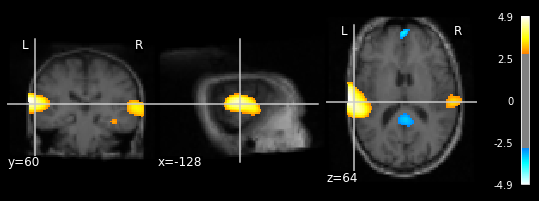

In [39]:
#* Plot statistical parametric map
Signif_thresh = 2.8
display = plotting.plot_stat_map(z_map, bg_img=ni_struct_img, threshold=Signif_thresh)
print('Voxels with significant fMRI (de)activation by contrast\n (superimposed over structural volume):')
plt.savefig(save_results + 'contrast_map.png', bbox_inches='tight', pad_inches=0, dpi=150);
plt.show()

### MCQ 

To finish the first graded lab, answer the next 2 *MCQ* questions about *GLM*, worth 1 point each. 

 * Q.6 What natural phenomenon is **not** modeled by convolving the boxcar with the HRF function?
 
    1. The time it takes for the blood oxygenated to deoxygenated ratio to change.
    2. MRI isn't a direct measure of brain activity. The HRF is the model of the measured response.
    3. The spatial and temporal variability of the BOLD response.
    3. The way the concentration of hydrogen atoms in the brain changes depending on metabolic consumption/demand.

In the next cell, **change the value of the variable `answer_q6`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [40]:
# Do not change the name of this variable
answer_q6 = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [41]:
assert answer_q6 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

 * Q.7 Assume that there is an experiment with two alternating tasks, one being hand movement, the other finger movement. They are modeled as the first and second regressors in the design matrix, with an additional third regressor being a constant baseline. What would be the contrast vector used for assessing the brain activity related to the hand movement, but not to the finger movement?
 
    1. $[-1, 1, 0]$
    2. $[1, 1, 1]$
    3. $[1, -1, 1]$
    4. $[1, -1, 0]$

In the next cell, **change the value of the variable `answer_q7`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [42]:
# Do not change the name of this variable
answer_q7 = 4
# YOUR CODE HERE
# raise NotImplementedError()

In [43]:
assert answer_q7 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

<div class = 'alert alert-success'>

Congratulations on finishing the first graded lab! Don't forget to hand it in. 
</div>